# Input formats

Data in Thunder can be loaded from a variety of formats and locations. We support several input formats for both image and series data, but also encourage a set of standard, recommended formats for these data, especially when working with large datasets.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from thunder import Colorize
image = Colorize.image

Loading Images
--------------
`Images` data are distributed collections of images or volumes. Two-dimensional images can be loaded from `png` or `tif` files, and three-dimensional volumes can be loaded from multi-page `tif` stacks, or flat binary volumes. For an example, we'll load a set of `tif` images by specifying a folder (note: these are small, highly downsampled images included with Thunder purely for demonstration and testing):

For these examples, first we find the location relative to the thunder installation

In [3]:
import os.path as pth
imagepath = pth.join(pth.dirname(pth.realpath(thunder.__file__)), 'utils/data/fish/images')

Now load the images

In [4]:
data = tsc.loadImages(imagepath, inputFormat='tif')

To look at the first image:

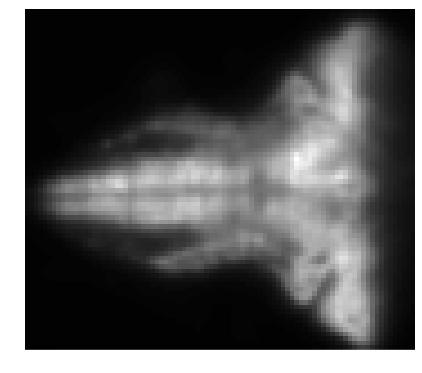

In [5]:
img = data.values().first()
image(img[:,:,0])

To check the dimensions of the images:

In [6]:
data.dims.count

(76, 87, 2)

And to check the total number of images:

In [7]:
data.nrecords

20

For any of these image formats, the images can be stored on a local file system (for local use), a networked file system (accessible to all nodes of a cluster), Amazon S3, or Google Storage. To load images from S3, the location of the data must be specified as a URI, with "s3://" or "s3n://" given as the scheme.
 For instance, data stored in an S3 bucket named "my-bucket" under keys named "my-data/images0.tif, my-data/images1.tif, ..." could be retrieved by passing '`s3n://my-bucket/my-data/images*.tif`' to ``loadImages``.

It's also easy to load only a subset of images (indexed assuming alphanumeric ordering): 

In [8]:
data = tsc.loadImages(imagepath, inputFormat='tif', startIdx=0, stopIdx=10)

In [9]:
data.nrecords

10

Flat binary files provide a particularly simple format for image data. We recommended storing one image per binary file, alongside a single file `conf.json` specifying the dimensions and the numerical type:

```
{
  "dims": [64, 64], 
  "dtype": "int16"
}
```

If this file is included in the folder with the binary files it will be used automatically, but the parameters can also be passed as arguments to `loadImages`

You can load an `Images` object directly from a `numpy` arrays in memory. To see that, first we'll collect the images  from the `tif` files into a local array.

In [10]:
data = tsc.loadImages(imagepath, inputFormat='tif', startIdx=0, stopIdx=10)
arrys = data.collectValuesAsArray()
arrys.shape

(10, 76, 87, 2)

We can now load this array directly as an `Images` object

In [11]:
datanew = tsc.loadImagesFromArray(arrys)

In [12]:
datanew.nrecords

10

In [13]:
datanew.dims.count

(76, 87, 2)

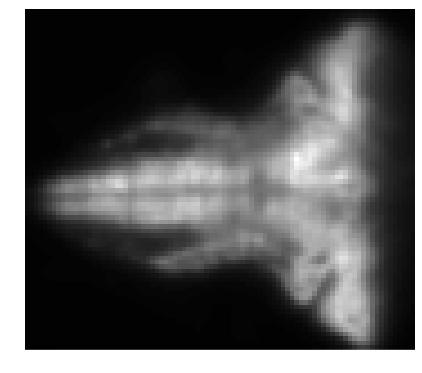

In [14]:
img = datanew.values().first()
image(img[:,:,0])

When loading n-dimensional array data, the first dimension is assumed to index the images, so a 4D array will be treated as a collection of 3D volumes, and a 3D array will be treated as a collection of 2D images.

In [15]:
datanew = tsc.loadImagesFromArray(arrys[:,:,:,0])

In [16]:
datanew.nrecords

10

In [17]:
datanew.dims.count

(76, 87)

Loading Series
--------------
A ``Series`` object is a distributed collection of one-dimensional arrays with tuple key identifiers. All arrays in a ``Series`` must have the same length. They can be loaded from flat text or binary files.

Text files must contain a line for each record, with numbers separated by spaces. The first numbers of each line will be interpreted as keys, and subsequent numbers will be interpreted as values. The number of keys is user-specified. As before, we'll load example series data from a small file included with Thunder purely for testing purposes (this is the ``iris`` dataset).

In [18]:
seriespath = pth.join(pth.dirname(pth.realpath(thunder.__file__)), 'utils/data/iris/')
data = tsc.loadSeries(seriespath + 'iris.txt', inputFormat='text', nkeys=1)

If data were split across multiple files, we could have also provided the folder name, rather than the file, and all file(s) of the given format would be loaded. Let's look at the first entry of the ``Series``:

In [19]:
data.first()

((0,), array([ 5.1,  3.5,  1.4,  0.2]))

The index is automatically calculated based on the length of the values array:

In [20]:
data.index

array([0, 1, 2, 3])

For comparison, you can look at the first raw line of the text file:

In [21]:
dataraw = sc.textFile(seriespath + 'iris.txt')
dataraw.first()

u'0 5.1 3.5 1.4 0.2'

Flat binary files must store each record as a contiguous sequence of bytes, with a fixed size in bytes for each record, including both keys and values. The number and numerical type of keys and records are most convieniently specified in a configuration file in the same directory as the data, but can also be specified as input arguments. Here, we show two ways of loading a binary version of the same ``iris`` data loaded previously.

In [22]:
data = tsc.loadSeries(seriespath + 'iris.bin', inputFormat='binary')
data.first()

((0,), array([ 5.1,  3.5,  1.4,  0.2]))

In this case, the number of keys and number of values in each record, along with the data types of the keys and values, are automatically read out from a ``conf.json`` file located in the same directory as ``iris.bin``. This file has the following simple JSON format.

```
{
  "keytype": "int16", 
  "valuetype": "uint8", 
  "nkeys": 3, 
  "nvalues": 240
}
```

When a ``conf.json`` file is unavailable, these parameters can also be passed as arguments to the ``loadSeries`` method:

In [23]:
path = seriespath + 'iris.bin'
data = tsc.loadSeries(path, inputFormat='binary', nkeys=1, nvalues=4, keyType='float', valueType='float')
data.first()

((0,), array([ 5.1,  3.5,  1.4,  0.2]))

Flat binary files are a particularly convienient format when exporting large data sets from other scientific computing environments, e.g. Matlab. For example, the data loaded above was written out from within Matlab using

```
f = fopen('iris.bin','w')
fwrite(f, [[0:149]' data]','double')
```

Where ``data`` is a matrix containing the data, and we append a column for the indices. Note that the data must be transposed due to ordering conventions.

Both text and binary data can be loaded from a single file or multiple files, stored on a local file system, a networked file system, Amazon S3, or HDFS. To load multiple files at once, specify a directory as the filename, or a wildcard pattern.

You can load ``Series`` data from local arrays saved in either numpy ``npy`` or Matlab ``MAT`` format. This is particular useful for local use, or for distributing a smaller data set for performing intensive computations. In the latter case, the number of partitions should be set to approximately 2-3 times the number of cores avaialble on your cluster, so that different cores can work on different portions of the data.

In [24]:
data = tsc.loadSeries(seriespath + '/iris.mat', inputFormat='mat', varName='data', minPartitions=5)
data.first()

(0, array([ 5.1,  3.5,  1.4,  0.2]))

In [25]:
data = tsc.loadSeries(seriespath + '/iris.npy', inputFormat='npy', minPartitions=5)
data.first()

(0, array([ 5.1,  3.5,  1.4,  0.2]))

Finally, like `Images`, a `Series` object can be constructed directly from a `numpy` array in memory. To see this, we'll `collect` the data we just loaded as an array, and then use it to create a new `Series` object

In [26]:
arry = data.collectValuesAsArray()

In [27]:
arry.shape

(150, 4)

In [28]:
datanew = tsc.loadSeriesFromArray(arry)

In [29]:
datanew.first()

((0,), array([ 5.1,  3.5,  1.4,  0.2]))

In [30]:
datanew.nrecords

150